### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [2]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


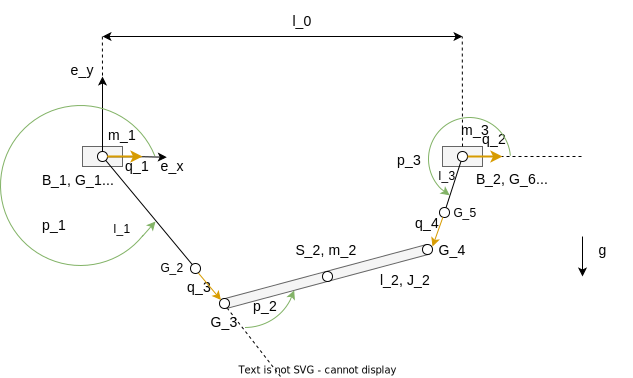

In [73]:
from IPython.display import Image
from IPython.core.display import SVG
#TODO: p2 is absolute now
SVG(filename='DAE_double_crane_fully_actuated.svg')

In [4]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates
nq = 4 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates

# vector of control inputs
aa = st.symb_vector("a1:{0}".format(nq+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T

st.make_global(ttheta, tthetad, tthetadd)

---

---

---

---

In [5]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

---

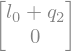

---

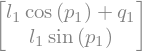

---

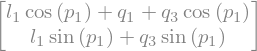

---

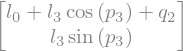

---

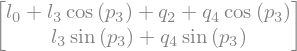

---

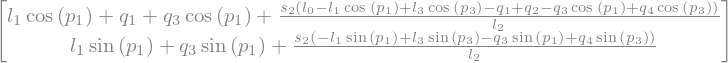

---

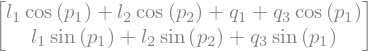

---

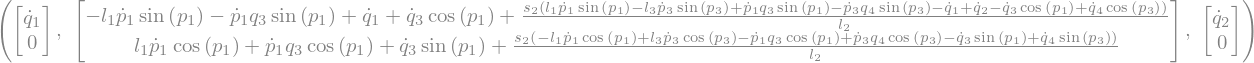

---

In [6]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# joints 2 and 3 (load joints)
G2 = G1 + Rz(p1)*ex*l1 ##:
G3 = G2 + Rz(p1)*ex*q3 ##:

# center of mass of load
G5 = G6 + Rz(p3)*ex*l3 ##:
G4 = G5 + Rz(p3)*ex*q4 ##:
S2 = G3 + (G4-G3)*s2/l2 ##:

# alternative route to G4 for constraints
G4b = G3 + Rz(p2)*ex*l2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

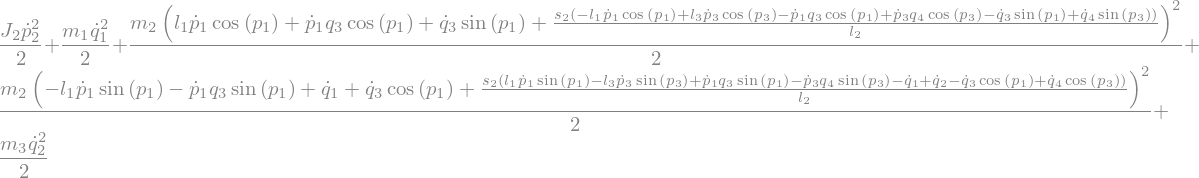

---

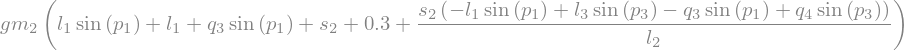

---

In [7]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0] + J2/2 * (pdot2)**2
T3 = (m3/2 * Sd3.T*Sd3)[0]

T = T1 + T2 + T3 ##:

# TODO: correct treatment for V ???
# max length of rope
q3max = 0.3
# potential energy, for l1 <= l2
V = m2*g*(l1+q3max + s2 + S2[1]) ##:

In [8]:
import pickle

# load model from pickle file instead of calculating it which takes a lot of time
loading_model = 1

if loading_model == 1:
    with open("DAE_fully_actuated_crane.pcl", "rb") as pfile:
        mod = pickle.load(pfile)

else:
    # dissipation included here! -d1*qdot1, -d4*qdot2 should be in control input function later
    external_forces = [0 , 0, 0, tau1, tau2, tau3, tau4]
    
    # model generation with Lagragian Mechanics
    mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=[G4 - G4b])
    
    # write the model to disk to save time in the next run of the notebook
    with open("DAE_fully_actuated_crane.pcl", "wb") as pfile:
        pickle.dump(mod, pfile)

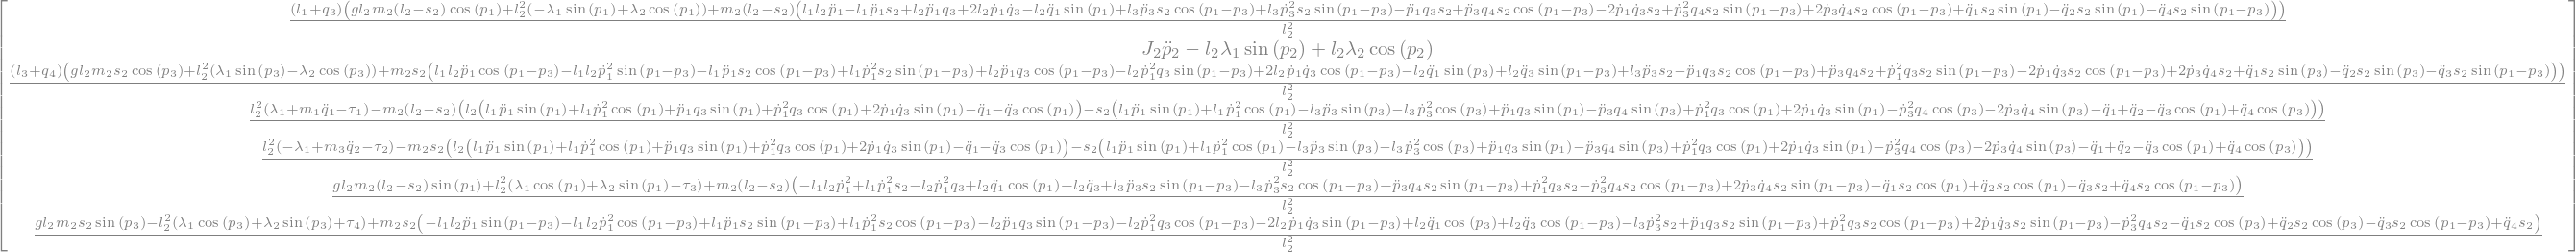

In [75]:
# implicit(=0) system equations 
mod.eqns

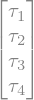

In [10]:
mod.tau

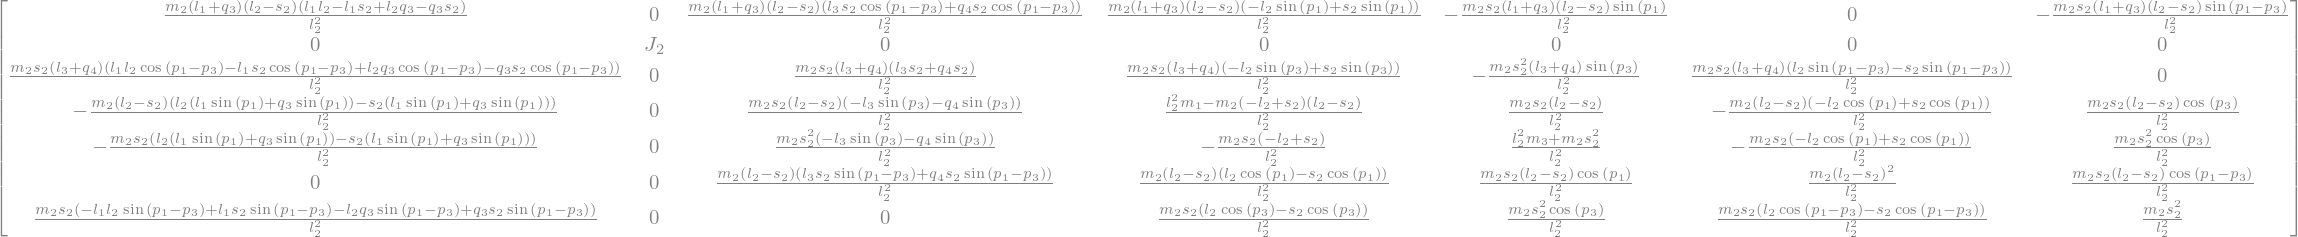

In [79]:
mod.eqns.jacobian(mod.ttdd)

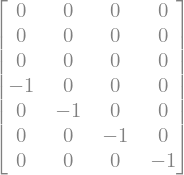

In [11]:
mod.eqns.jacobian(mod.tau)

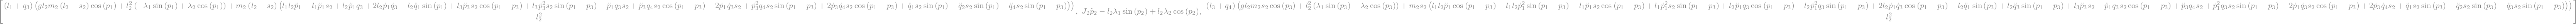

In [12]:
mod.eqns[0:3]

### Creation of DAE System

In [13]:
parameter_values = list(dict(s2=0.15, m1=0.45, m2=0.557, m3=0.45, J2=0.000221, mc1b=39, mc2b=36.3, d1=9.76, d4=11.2, l0=0.5, l1=0.4, l2=0.3, l3=0.4, g=9.81).items()) ##:
# tbd: J2, d1, d4

parameter_values := [('s2', 0.15),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('J2', 0.000221),
 ('mc1b', 39),
 ('mc2b', 36.3),
 ('d1', 9.76),
 ('d4', 11.2),
 ('l0', 0.5),
 ('l1', 0.4),
 ('l2', 0.3),
 ('l3', 0.4),
 ('g', 9.81)]

---

#### Visualization of kinematics for debugging and placement of initial values

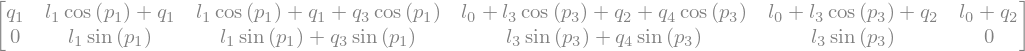

---

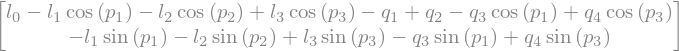

---

In [14]:
# matrix of joints
joints = sp.Matrix.hstack(G1, G2, G3, G4, G5, G6) ##:
joints = joints.subs(parameter_values)
# constraints equations (implicit) as vector
constraints = mod.constraints ##:
constraints = constraints.subs(parameter_values)

# numerical functions for joints and constraints
constraints_func = sp.lambdify(ttheta, constraints, modules="numpy")
joints_func = sp.lambdify(ttheta, joints, modules="numpy")

# cost function of constraints, theta_var: variable coordinates to be optimized, theta_const: constant coordinate (manipulated by slider later)
def constraint_cost(theta_var, theta_const):
    err = constraints_func(theta_var[0], theta_const[0], theta_var[1], theta_const[1], theta_const[2], theta_const[3], theta_const[4])
    return err[0]**2 +err[1]**2 # squared error

In [15]:
%matplotlib inline

init_theta = []

from ipywidgets import interact
@interact(p2=(-2, 2, .1), q1=(-1, 1, .1), q2=(-1, 1, .1), q3=(0, 0.3, .1), q4=(0, 0.3, .1))
def plot_func(p2, q1, q2, q3, q4):
    res = fmin(constraint_cost, x0=[5, 4], args=([p2, q1, q2, q3, q4],), disp=0, ftol=1e-15)

    # dependent coordinates
    p1, p3 = res
    jc = joint_coords = joints_func(p1, p2, p3, q1, q2, q3, q4)

    plt.plot(jc[0, :], jc[1, :], "ok", ms=7)
    plt.plot(jc[0, :], jc[1, :], "b-")
    plt.axis("equal")
    plt.axis([-0.5, 1.4, -1.5, 0.5])
    
    init_theta[:] = [p1, p2, p3, q1, q2, q3, q4]
    const_err = constraints_func(*init_theta)
    
    str_coords = ( f'Initial Values:\n'
                   f'p1: {p1}\n'
                   f'p2: {p2}\n'
                   f'p3: {p3}\n'
                   f'q1: {q1}\n'
                   f'q2: {q2}\n'
                   f'q3: {q3}\n'
                   f'q4: {q4}\n'
                   f'error of constraints: \n {const_err} \n')
    print(str_coords)

interactive(children=(FloatSlider(value=0.0, description='p2', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…

#### DAE system for simulation

In [16]:
# generate numerical DAE system from implicit system equations
dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [17]:
# degrees of freedom of DAE system
dae.ndof

In [18]:
# DAE's states and its derivatives
dae.yy ##:T
dae.yyd ##:T

---

---

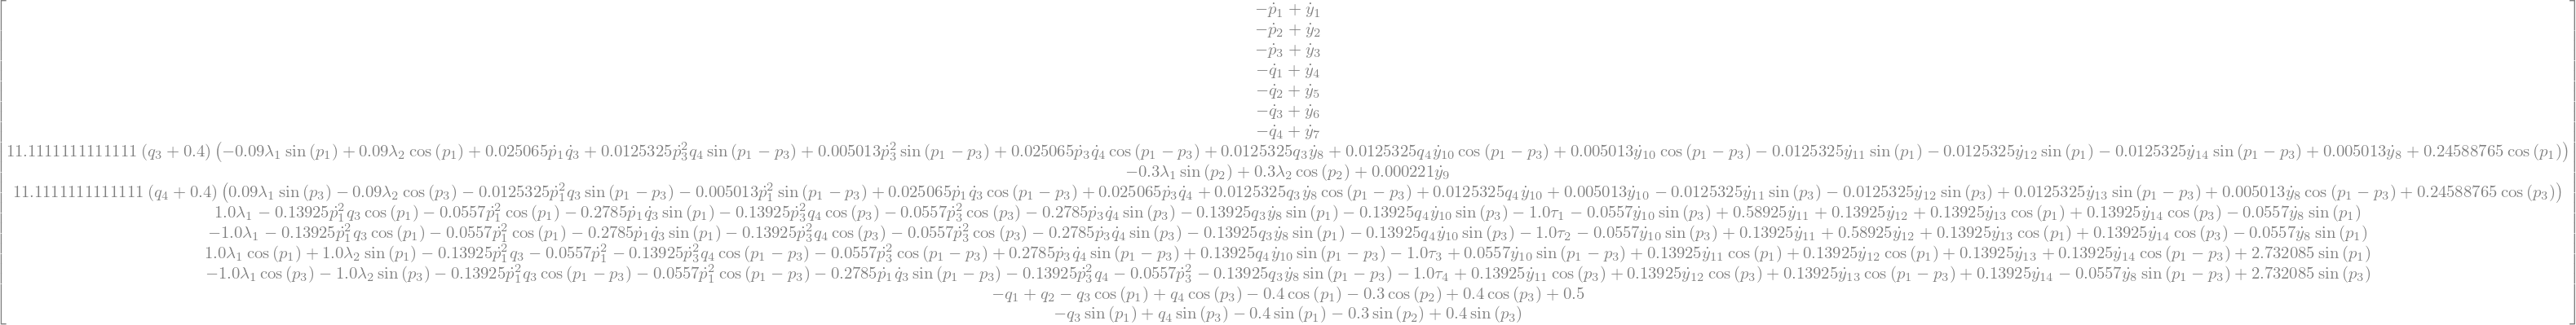

In [19]:
# implicit equations of the DAE system
dae.eqns

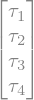

In [20]:
# control input vector of DAE system
dae.mod.tau

In [21]:
# define closed loop (usage of yy) control function for input
# di*yy[] terms represent dissipation in carts
def new_input_func(yy, t):
    u1 = 0 #mc1b.subs(parameter_values)*yy[1] - d1.subs(parameter_values) * yy[8]
    u2 = 0 #mc2b.subs(parameter_values)*yy[1] - d4.subs(parameter_values) * yy[9]
    u3 = 0
    u4 = 0
    return [u1, u2, u3, u4]

# set as input of DAE system
dae.input_func = new_input_func ##:

(dae.input_func) := <function __main__.new_input_func(yy, t)>

---

In [22]:
dae.eqns.subs([(q3, 0), (q4, 0)])

### check error of constraints for initial values
dae.constraints_func(*init_theta) ##:

# calculate consistent initial values from latest visualization
yy0, yyd0 = dae.calc_consistent_init_vals(p2=init_theta[1], q1=init_theta[3], q2=init_theta[4], q3=init_theta[5], q4=init_theta[6], _ftol=1e-9) ##:

t0 = 0

# evaluation of implicit DAE System (should be almost 0 if initial values fulfill the model)
dae.model_func(t0, yy0, yyd0) ##:

# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

(dae.constraints_func(*init_theta)) := array([-1.23194337e-08,  1.53282417e-08])

---

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 111
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 71


(yy0, yyd0) := (array([ 1.36943840e+00,  0.00000000e+00,  1.77215425e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e-01,  1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.76401767e-16, -1.83728804e-16]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.92400004e+00,  2.42028619e-13,  3.92400001e+00,  1.62130975e-15, -1.38492033e-15, -9.61179775e+00, -9.61179775e+00, -0.00000000e+00, -0.00000000e+00]))

---

(dae.model_func(t0, yy0, yyd0)) := 
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.24043516e-16, -1.63031627e-18, -3.85494106e-16, -8.32667268e-17, -8.32667268e-17, -4.44089210e-16,  0.00000000e+00,  1.92823584e+01, -3.34954840e+00])

---

AssertionError: 

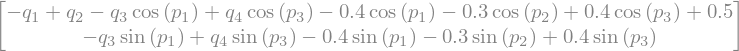

In [23]:
dae.constraints

In [71]:
ntt = 7
ttheta = yy0[:ntt]
ttheta_d = yy0[ntt:2*ntt]
external_forces = dae.input_func(yy0, t0)
ttheta_dd = dae.acc_of_lmd_func(*npy.concatenate((yy0, external_forces)))

c2 = dae.constraints_dd_func(*npy.concatenate((ttheta, ttheta_d, ttheta_dd)))
c2 = npy.atleast_1d(c2) ##:

c2 := array([19.28235842, -3.3495484 ])

---

In [70]:
args = npy.concatenate((yy0, yyd0, external_forces))
ode_part = dae.deq_func(*args) ##:

ode_part := array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.24043516e-16, -1.63031627e-18, -3.85494106e-16, -8.32667268e-17, -8.32667268e-17, -4.44089210e-16,  0.00000000e+00])

---

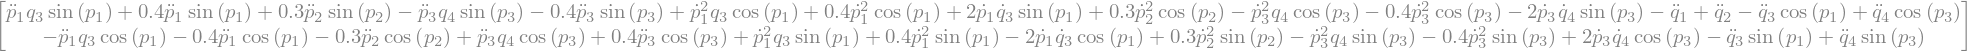

---

In [80]:
constraints_dd = st.time_deriv(dae.constraints, dae.mod.tt, order=2) ##:

In [115]:
sub_paras = npy.concatenate(([(x, y) for (x, y) in zip(dae.yy, yy0)], [(a, b) for (a, b) in zip(dae.yyd, yyd0)]))

for eqs in dae.eqns:
    print(eqs.subs(sub_paras))
    
print("---")    

for constr in constraints:
    print(constr.subs(sub_paras))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.77635683940025e-15
-2.11312600056177e-19
-6.10622663543836e-16
-1.0*tau1 - 2.22044604925031e-16
-1.0*tau2 - 2.77555756156289e-16
-1.0*tau3 - 4.44089209850063e-16
6.66133814775094e-16 - 1.0*tau4
8.51378929161983e-10
-1.22768353816305e-9
---
0.398710315770151*pddot1 + 0.0886560619984019*pddot2 - 0.487366376540869*pddot3 - qddot1 + qddot2 - 0.603423844734252*qddot3 - 0.223374260087627*qddot4
-0.301711922367126*pddot1 - 0.286600946737682*pddot2 - 0.111687130043813*pddot3 - 0.797420631540302*qddot3 + 0.974732753081738*qddot4


In [70]:
# defining assimulo problem
model = Overdetermined_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'gantry crane'

# indicate which components of y are differential (1) and which are purely algebraic (0)
model.algvar = dae.diff_alg_vars ##:

# definition of simulation of DAE system with ODASSL solver
sim = SOLVER(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

---

In [71]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# simulation of DAE system
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.


capi_return is NULL
Call-back cb_res_in_odassl__user__routines failed.


KeyboardInterrupt: 

In [ ]:
# trajectories of coordinates and its velocities
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("theta")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("dot theta")

####  Visualization and Animation of simulation solution

In [ ]:
joint_pos_expr = st.col_stack(G1, G2, G3, G4).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt_sol[1] - tt_sol[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*ttheta_sol[i, :])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(ttheta_sol.shape[0]), interval=tt_sol[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())





*Preliminary Conclusion*

→ Behavior looks more or less realistic - up to the configurations where $p_1$ is an integer multiple of $\pi$ (joint is fully streched or fully bended). Probably there are singularities.

#### Save animation

In [ ]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
writer = animation.FFMpegWriter(fps=30)
ani.save("gantry_crane.webm", writer=writer)

In [ ]:
%%HTML
<video width="320" height="240" controls>
  <source src="gantry_crane.webm" type="video/webm">
</video>